In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from sklearn.feature_selection import chi2
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.ensemble import BalancedRandomForestClassifier
from mrmr import mrmr_classif

# Quiet setting warnings
pd.options.mode.chained_assignment = None

# Background

The Departments of Neurology and Neurosurgery would like to study the possibility of predicting which of their patients is at risk of presenting a brain stroke. Since it is known that several factors such as smoking, hypertension or obesity are related to an increased risk of stroke, they designed a multi-institutional study collecting that information from a large number of patients who were followed up to record whether they had a stroke or not.

# Goals

- To identify if the risk of stroke can be identified using the collected dataset.  

- Build and evaluate the performance of: a random forest classifier, a linear support vector machine classifier, and a logistic regression classifier. Feel free to evaluate non-linear support vector machines if curious.  

- Discuss the similarities and differences between the performance of the three trained classifiers in terms of ROC curve analysis and the distributions of their probabilistic predictions.  

- Explain which approach you would deploy clinically and justify the reasons for it.  

In [2]:
# Set wkdir
WORK_DIR = os.getcwd()

# Import and display data
data = pd.read_csv(f'{WORK_DIR}/brain_stroke.csv')
data.columns = data.columns.str.lower().str.replace(' ', '_')
data.head(5)

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


# Functions

Below are some functions I'll use for processing/visualizing the data.

In [3]:
def X_y_split(df, target: str, to_numpy: bool):
    '''
    Function to split df into features (X) and target (y)
    to_numpy boolean flag can be used to convert X and y outputs to numpy arrays
    '''
    X = df.loc[:, df.columns != target]
    y = df.loc[:, target]
    if to_numpy:
        return X.to_numpy(), y.to_numpy()
    else:
        return X, y
    

def numFeature_distribution(df, n_col, bins, width, height, hspace, wspace):
    '''
    Function to plot the distribution of each numeric feature in a data frame
    '''

    # Extract features to plot - only numeric features will work here
    numFeatures = list(df.select_dtypes(include=[np.number]).columns)
    
    # Set figure space
    plt.style.use('default')
    n_row = int(np.ceil(len(numFeatures)/n_col))
    fig, axs = plt.subplots(n_row, n_col, figsize=(width, height), gridspec_kw={"hspace": hspace, "wspace": wspace})
    plots = []
    for ax in axs:
        try:
            for plot in ax:
                plots.append(plot)
        except:
            plots.append(ax)

    # Plot distributions
    for i, feature in enumerate(numFeatures):
        
        # Plot
        sns.histplot(data=df, x=feature, ax=plots[i], color='tab:blue', bins=bins)
        plots[i].set_title(feature, fontsize=12)
        plots[i].set_xlabel('')
        
    # Remove subplots with no feature to plot
    rm_count = len(plots) - len(numFeatures)
    if rm_count:
        rm_axes = plots[-rm_count:]
        for plot in rm_axes:
            fig.delaxes(plot)
        
    plt.show()
        

def catFeature_balance(df, n_col: int, width: float, height: float, hspace: float, wspace: float):
    '''
    Function to plot the balance of each categorical feature in a data frame
    '''
    
    # Set figure space
    plt.style.use('default')
    catFeatures = df.columns
    n_row = int(np.ceil(len(catFeatures)/n_col))
    fig, axs = plt.subplots(n_row, n_col, figsize=(width, height), gridspec_kw={"hspace": hspace, "wspace": wspace})
    plots = []
    if len(catFeatures) > 1:
        for ax in axs:
            try:
                for plot in ax:
                    plots.append(plot)
            except:
                plots.append(ax)
    else:
        plots.append(axs)

    # Plot distributions
    for i, feature in enumerate(catFeatures):
        
        # Set count df for plot
        labels = list(set(df[feature]))
        counts = [list(df[feature]).count(c) for c in labels]
        plot_df = pd.DataFrame({
            'labels': [str(label) if label is not np.nan else "Missing" for label in labels], 
            'counts': counts
        })
        
        # Plot
        sns.barplot(data=plot_df, y="labels", x="counts", ax=plots[i], color="tab:blue", edgecolor = "black")
        plots[i].set_title(feature, fontsize=12)
        plots[i].set_ylabel('')
        
    # Remove subplots with no feature to plot
    rm_count = len(plots) - len(catFeatures)
    if rm_count:
        rm_axes = plots[-rm_count:]
        for plot in rm_axes:
            fig.delaxes(plot)
        
    plt.show()
    

def correlation_plot(X, width: float, height: float):
    '''
    Function to generate correlation plot
    Source for correlation plot style: https://seaborn.pydata.org/examples/many_pairwise_correlations.html
    '''
    
    # Compute the correlation matrix
    corr = X.corr()
    
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    fig, ax = plt.subplots(figsize=(width, height))

    # Draw the heatmap with the mask and correct aspect ratio
    plt.style.use('default')
    cmap = sns.diverging_palette(220, 20, s=60)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0, square=True, 
                annot=True, linewidths=1, cbar_kws={"shrink": .5})
    ax.set_title('Correlation Plot of Numeric Features', size=14)
    plt.show()    
    

    
def chi2Test(catDF):
    '''
    Function to perform pairwise chi-squared test (i.e. perform chi-squared test for each pair of features)
    
    Inputs:
        catDF: Pandas data frame containing only categorical features
        
    Outputs:
        A DF is returned, similar to a correlation matrix, but with p-values returned by each chi-squared test
    '''
    # Initialize the values in this matrix with 0
    chi2_DF = pd.DataFrame(
        data = [(0 for i in range(len(catDF.columns))) for i in range(len(catDF.columns))], 
        columns = list(catDF.columns)
    )
    chi2_DF.set_index(pd.Index(list(catDF.columns)), inplace=True)

    # Finding p_value for all columns and putting them in the resultant matrix
    for i in list(catDF.columns):
        for j in list(catDF.columns):
            if i != j:
                chi2_val, p_val = chi2(np.array(catDF[i]).reshape(-1, 1), np.array(catDF[j]).reshape(-1, 1))
                chi2_DF.loc[i,j] = p_val
                
    # Return matrix
    return(chi2_DF.round(decimals=3))


def chi2Plot(chi2_DF, width: float, height: float):
    '''
    Function to plot the chi-squared p-values that result from chi2Test() function above as a heatmap
    '''
     # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(chi2_DF, dtype=bool))

    # Set up the matplotlib figure
    fig, ax = plt.subplots(figsize=(width, height))

    # Draw the heatmap with the mask and correct aspect ratio
    plt.style.use('default')
    sns.heatmap(chi2_DF, cmap=sns.cubehelix_palette(as_cmap=True), center=None, mask=mask, vmin=0, vmax=1, 
                square=True, annot=True, linewidths=1, cbar_kws={"shrink": .5})
    ax.set_title('Chi-Squared p-Values of Categorical Features', size=14)
    plt.show()
    

def encodeCategories(X, drop: bool):
    '''
    Function to encode categorical features
    Features with two categories will be encoded as binary
    Features with more than two categories will be one-hot-encoded
    '''
    # Copy df 
    df = X.copy()
    categorialColumnNames_list = df.select_dtypes(include=['object']).columns.values.tolist()
    featureCategoryCount_dict = {feature: len(set(df[feature])) for feature in categorialColumnNames_list}
    
    # Display message
    print('Encoding categorical features...\n')
    
    # Encode feature based on number of categories
    for feature, categoryCount in featureCategoryCount_dict.items():

        # Convert binary feature to binary 0, 1
        if categoryCount == 2:

            # Encode column
            feat0, feat1 = sorted(list(set(df[feature])))
            df[feature] = df[feature].map({feat0: 0.0, feat1: 1.0})

            # Display which category is encoded 0 and 1
            print(feature + ' encoded as binary')
            print(f'   0: {feat0}')
            print(f'   1: {feat1}\n')

        # One-hot-encode feature with more than 2 categories
        elif categoryCount > 2:

            # Code adapted from Antonio Perez, PhD
            # Encode column
            if drop:
                encoder = OneHotEncoder(handle_unknown='error', drop='first', sparse=False)
            else:
                encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
            encoder.fit(df[feature].to_numpy().reshape(-1, 1))
            encodedData = encoder.transform(df[feature].to_numpy().reshape(-1, 1))

            # Copy to data frame
            for i in range(encodedData.shape[1]):
                if type(encoder.categories_[0][i]) == str:
                    df[f'{feature}_{encoder.categories_[0][i]}'] = encodedData[:, i]

            # Drop original column
            df.pop(feature)

            # Display message
            print(f'{feature} one-hot-encoded\n')

        # Safe gaurd against features with only one category
        else:
            pass
        
    return df
    
    

# EDA
## Missing Data

In [4]:
# View missing data for 50 sample set - no missing data
print('Missing Data:')
print(data.isnull().sum())

Missing Data:
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64


## Visualizing Target & Feature Balance/Distributions

In [5]:
# Split into target/features
X, y = X_y_split(data, target='stroke', to_numpy=False)

# Split features in numeric/categorical sets
numFeatures = ['age', 'avg_glucose_level', 'bmi']
catFeatures = [feat for feat in X.columns if feat not in numFeatures]
X_numDF = X[numFeatures]
X_catDF = X[catFeatures]

### Numeric Features

BMI has an approximate Gaussian distribution. Age and average glucose level clearly have non-normal distributions. No obvious outliers are present here.

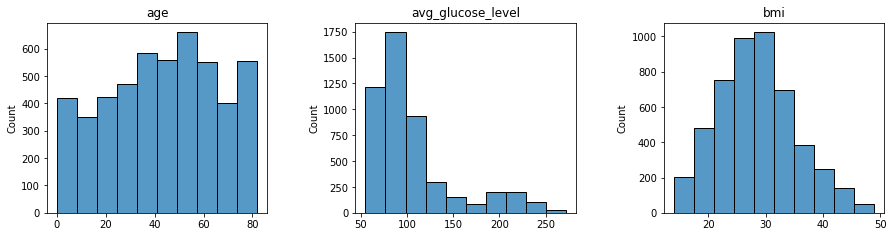

In [6]:
# Plot distributions
numFeature_distribution(df=X_numDF, n_col=3, width=15, height=3.5, bins=10, hspace=0.3, wspace=0.4)

### Categorical Features

Some heavy class imbalance exists for a few key predictors, esp. hypertension and heart disease.

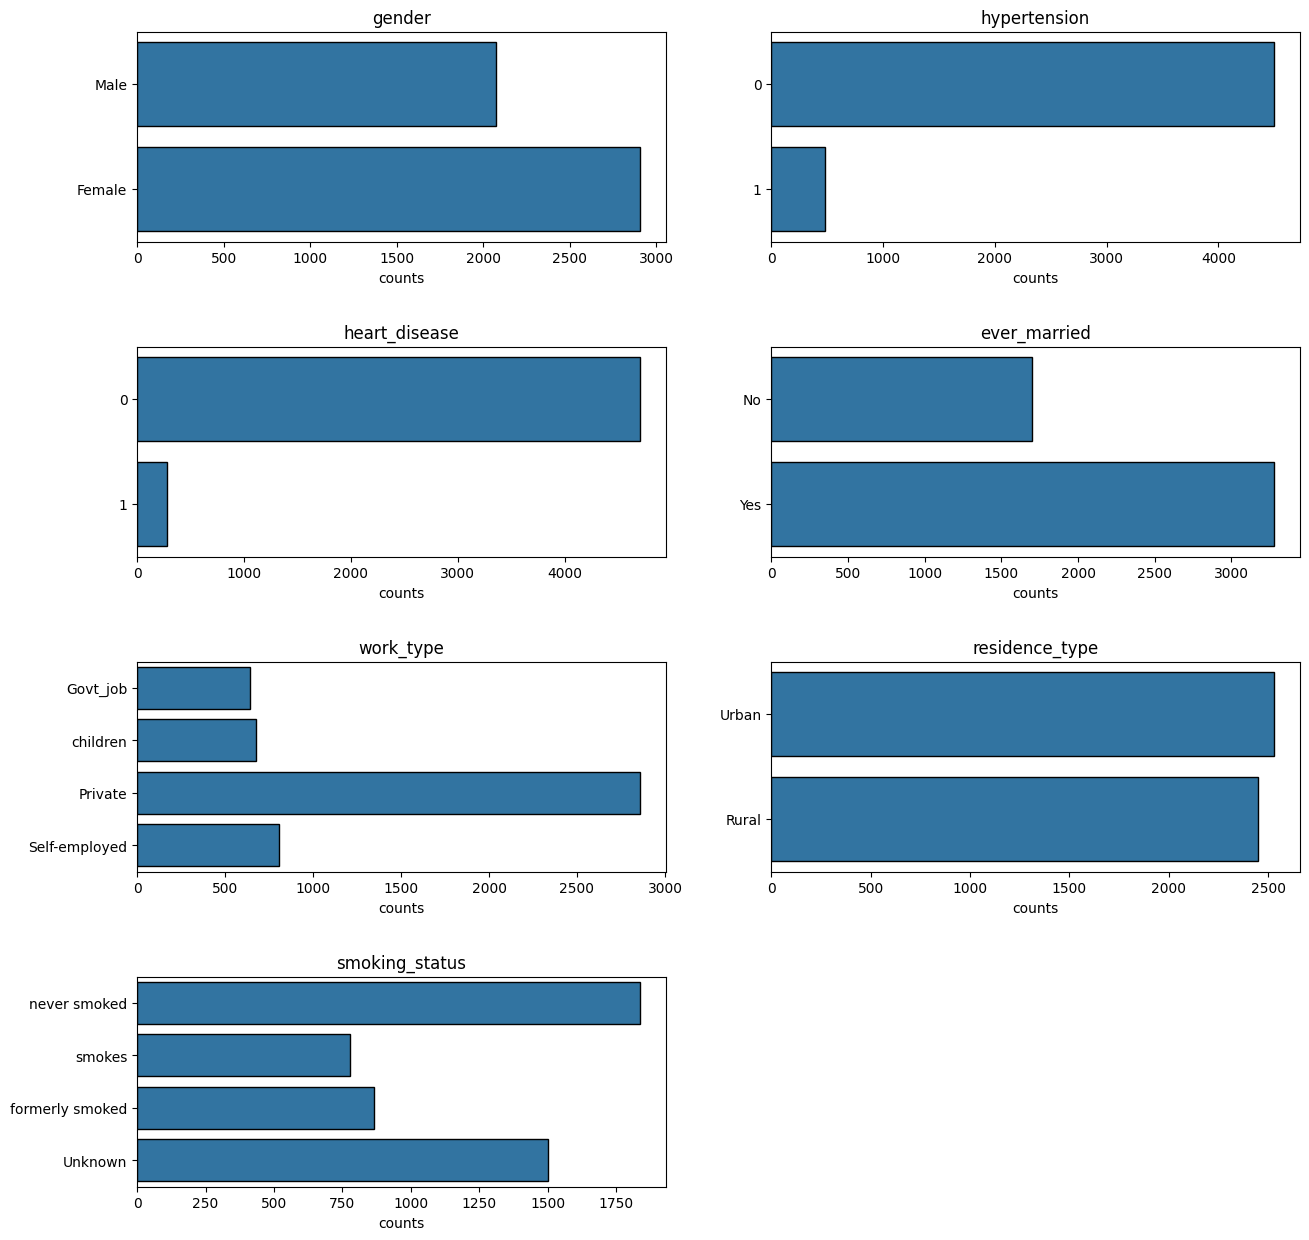

In [7]:
# Convert binary variables to categorical for plot
X_catDF['hypertension'] = X_catDF['hypertension'].astype('object')
X_catDF['heart_disease'] = X_catDF['heart_disease'].astype('object')
X_catDF.dtypes

# Plot class balances
catFeature_balance(df=X_catDF, n_col=2, width=15, height=15, hspace=0.5, wspace=0.2)

### Target Class Balance

Again, the target is quite imbalanced. We will keep this in mind during model construction/selection/performance evaluation.

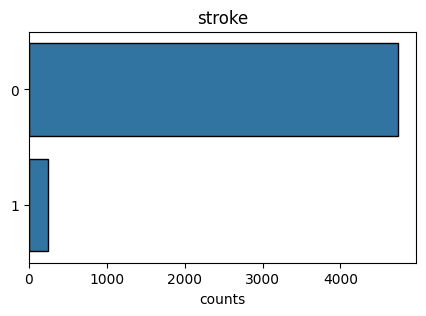

In [8]:
# Convert pandas series to df and data type to object
y_DF = y.to_frame()
y_DF['stroke'] = y_DF['stroke'].astype('object')

# Plot
catFeature_balance(df=y_DF, n_col=1, width=5, height=3, hspace=0, wspace=0)

## Encode Categorical Features

In [9]:
X_encodedDF = encodeCategories(X_catDF, drop=False)
X_encodedDF.columns = X_encodedDF.columns.str.lower().str.replace(' ', '_')
X_encodedDF.head(5)

Encoding categorical features...

gender encoded as binary
   0: Female
   1: Male

hypertension encoded as binary
   0: 0
   1: 1

heart_disease encoded as binary
   0: 0
   1: 1

ever_married encoded as binary
   0: No
   1: Yes

work_type one-hot-encoded

residence_type encoded as binary
   0: Rural
   1: Urban

smoking_status one-hot-encoded



,gender,hypertension,heart_disease,ever_married,residence_type,work_type_govt_job,work_type_private,work_type_self-employed,work_type_children,smoking_status_unknown,smoking_status_formerly_smoked,smoking_status_never_smoked,smoking_status_smokes
0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


## Multicollinearity, Independence Tests & Feature Selection
### Correlation Plot of Numeric Features

There are no obvious correlations among the numeric features that seem to be problematic.

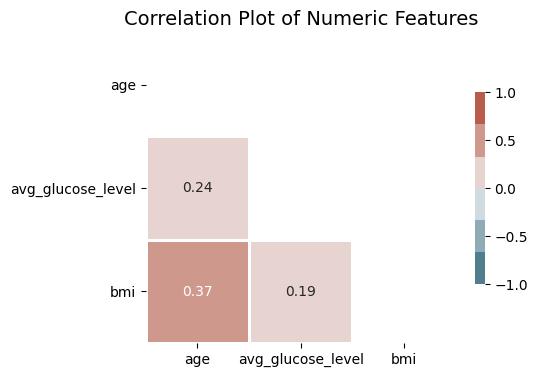

In [10]:
correlation_plot(X=X_numDF, width=5, height=5)

### Chi-Squared Test Results of Categorical Features

It appears that some categorical features may not be completely independent. Of course, one-hot-encoded variables of the same parent are likely to form linear combinations with one another, so we can likely ignore the significant p-values between these (i.e. ignore smoking status pairwise results). Interestingly, heart disease and hypertension seem fairly correlated. In a normal study this type of correlation is worth examining further.

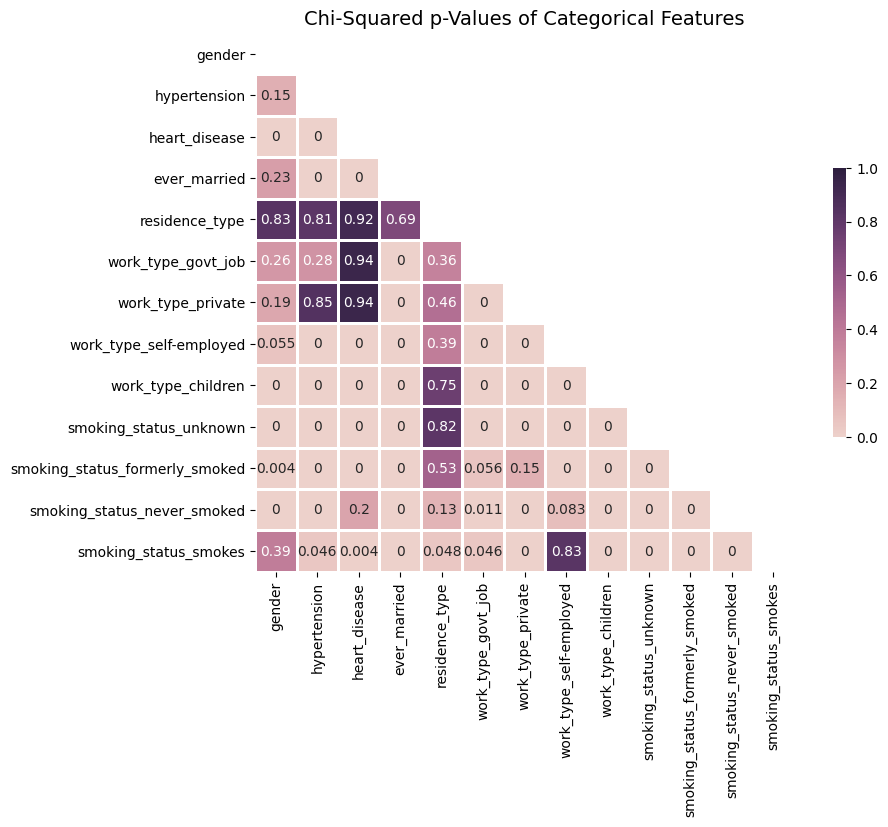

In [11]:
chi2_DF = chi2Test(X_encodedDF)
chi2Plot(chi2_DF, width=10, height=7)

### Feature Selection with mRMR

mRMR is a popular manner of selecting the K "best" features for predicting the specified target. Below is an ordered list of the most important features as determined by mRMR. I'll initially go ahead and leave all features in for the sake of this exercise. It could be interesting to see how selecting the top features (e.g. top 10 features below) impacts our modeling results. It will also be interesting to see if there are any consistencies between this list and the list of feature importances that results from our random forest model.

In [12]:
X_model = pd.concat([X_numDF, X_encodedDF], axis=1)
for i, feature in enumerate(mrmr_classif(X=X_model, y=y, K=len(X_model)), 1):
    print(f'{i}: {feature}')

100%|██████████| 16/16 [00:01<00:00, 12.44it/s]

1: age
2: avg_glucose_level
3: heart_disease
4: hypertension
5: ever_married
6: residence_type
7: smoking_status_formerly_smoked
8: work_type_self-employed
9: work_type_children
10: bmi
11: smoking_status_unknown
12: gender
13: smoking_status_smokes
14: work_type_private
15: smoking_status_never_smoked
16: work_type_govt_job


## Final Data Set for Modeling

In [13]:
# Merge categorical data with numeric features
# NOTE: We'll need to standardize our numeric features. This will be done in the cross-validation process, however.
X_model = pd.concat([X_numDF, X_encodedDF], axis=1)

# Get feature information
# These are column indices for numeric features; need indices and not names for subsetting numpy matrices
numFeaturesIdx = [X_model.columns.get_loc(column) for column in X_numDF.columns if column in X_numDF.columns]
featureNames = X_model.columns

# Building Classifiers: Random Forest, Linear SVM & Logistic Regression

Here we will build and evaluate the performance of a random forest classifier, a linear SVM classifier, and a logistic regression classifier. We will use stratified k-fold cross validation here with a fixed k=10. Typically we'd likely want to include some sort of hyperparameter tuning for each model. For the sake of this assignment we'll just 

In [14]:
def scaleNoLeak(X_train, X_test, numFeaturesIdx: list):
    '''
    Function to scale numeric features in training and test sets
    Scaler is trained on the training set and then applied to the test set to prevent leak into test set
    numFeaturesIdx is a list containing the indices of numeric columns
    '''
    
    # Extract numeric features from each set to standardize; don't want to include categorical features in this step
    X_trainNum = X_train[:, numFeaturesIdx]
    X_testNum = X_test[:, numFeaturesIdx]
    
    # Standardize features - train scalar on train set (hold out test set) to prevent test set leak
    scaler = StandardScaler()                           # Initialize scaler
    X_trainNumScaled = scaler.fit_transform(X_trainNum) # Train scalar on training set and tranform training set
    X_testNumScaled = scaler.transform(X_testNum)       # Transform test set using fit from training set
    
    # Replace non-standardized features with standardized features
    X_train[:, numFeaturesIdx] = X_trainNumScaled
    X_test[:, numFeaturesIdx] = X_testNumScaled
    
    # Return standardized data set
    return X_train, X_test


def clf_perfEval(y_true, y_pred, focus):
    '''
    Function to evaluate performance of Logistic Regression (or any binary) classifier
    
    Inputs:
        y_true: True values of targets
        y_pred: Predicted values of targets (as determined by trained model)
        focus: Focus on positive or negative class metrics
        
    Outputs:
        Confusion matrix visual
        Classification report
    '''
    
    # Check focus input is correct
    focus_types = ['+', '-', None]
    if focus not in focus_types:
        raise ValueError(f'Invalid focus argument. Expected one of: {focus_types}.')
    
    # Performance evaluation
    y_true = pd.Series(list(y_true), name='Actual')
    y_pred = pd.Series(list(y_pred), name='Predicted')
    confusionDF = pd.crosstab(y_true, y_pred)
    
    # Focused metrics
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    neg_pred_value = tn / (tn + fn)
    specificity = tn / (tn + fp)
    
    # Print confusion matrix
    print(confusionDF)
    print('\n')
    
    # Print relevant focus metrics
    if focus == '+':
        print('Positive Class Metrics:\n')
        print(f'   Precision: {round(precision, 3)}')
        print(f'   Recall: {round(recall, 3)}\n')
        
    elif focus == '-':
        print('Negative Class Metrics:\n')
        print(f'   Accuracy in Negative Predictions: {round(neg_pred_value, 3)}')
        print(f'   Specificity: {round(specificity, 3)}\n')
        
    else:
        pass
    
    # Classification report
    print(classification_report(y_true, y_pred))


def clf_ROC(y_true, y_score, roc_label):
    '''
    Function to plot ROC curve from classification results
    
    Inputs:
        y_true: True values of targets
        y_score: Target scores (probability estimates of the positive class)
        roc_label: Label for plot
        
    Outputs:
        ROC curve with AUC score reported
    '''
    
    # ROC, AUC
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc = roc_auc_score(y_true, y_score)    
    
    # ROC Curve
    #plt.figure()
    plt.plot(fpr, tpr, marker='.', label=f'{roc_label} (AUC = {round(auc, 3)})')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.legend(loc='lower right')
    #plt.show()
    
    

## Hyperparameter Tuning
Prior to comparing models, we'll perform quick grid searches to determine optimal hyperparameters for each model type. I'm going to go ahead and use ROC-AUC as our deciding metric since class imbalance is present and accuracy won't be as representative of performance. Note that we'll use a more verbose k-fold cross validation process in the model selection portion of this report to ensure everything under the hood is working as intended.

In [15]:
# Prepare preprocessing steps that will allow us to apply StandardScaler() to specific cols (numFeatures)
numFeatures = list(X_numDF.columns)
numTransformer = Pipeline(steps=[('scaler', StandardScaler())])
featScaler = ColumnTransformer(transformers=[('featScaler', numTransformer, numFeatures)])

# Insantiate k-fold CV
kfold_CV = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

### RF

In [16]:
# RF pipeline
pipe_RF = Pipeline(
    steps=[('featScaler', featScaler), # featScaler will apply to numeric features only
           ('RF', RandomForestClassifier(n_jobs=-1, random_state=1, class_weight='balanced'))]
)

# Set hyperparameter search space
hp_space = {
    'RF__n_estimators': [100, 500, 1000],
    'RF__max_depth': [None, 50, 100, 150],
    'RF__min_samples_leaf': [1, 2, 3],
    'RF__min_samples_split': [2, 3, 4],
}

# Define, execute and summarize search
search = GridSearchCV(pipe_RF, hp_space, scoring='roc_auc', n_jobs=-1, cv=kfold_CV)
result = search.fit(X_model, y)

# Summarize result
print(f'Best AUC: {result.best_score_}')
print(f'Best Hyperparameters: {result.best_params_}')

Best AUC: 0.8105386652810115
Best Hyperparameters: {'RF__max_depth': None, 'RF__min_samples_leaf': 3, 'RF__min_samples_split': 2, 'RF__n_estimators': 1000}


max_depth=None & min_samples_split=2 are default, so no need to specify these in the model later

### RF with Under-Sampled Majority Class (RF-USM)
This is a separate implementation from the iblearn package, which randomly under-samples each boostrap sample in the random forest to balance it. Documentation can be found here: https://imbalanced-learn.org/stable/references/generated/imblearn.ensemble.BalancedRandomForestClassifier.html.

In [17]:
# Balanced RF pipeline
pipe_balRF = Pipeline(
    steps=[('featScaler', featScaler), # featScaler will apply to numeric features only
           ('balRF', BalancedRandomForestClassifier(n_jobs=-1, random_state=1))]
)

# Set hyperparameter search space
hp_space = {
    'balRF__n_estimators': [100, 500, 1000],
    'balRF__max_depth': [None, 50, 100, 150],
    'balRF__min_samples_leaf': [1, 2, 3],
    'balRF__min_samples_split': [2, 3, 4],
}

# Define, execute and summarize search
search = GridSearchCV(pipe_balRF, hp_space, scoring='roc_auc', n_jobs=-1, cv=kfold_CV)
result = search.fit(X_model, y)

# Summarize result
print(f'Best AUC: {result.best_score_}')
print(f'Best Hyperparameters: {result.best_params_}')

Best AUC: 0.8396671349943354
Best Hyperparameters: {'balRF__max_depth': None, 'balRF__min_samples_leaf': 3, 'balRF__min_samples_split': 2, 'balRF__n_estimators': 1000}


max_depth=None & min_samples_split=2 are default, so no need to specify these in the model later

### Linear SVM

In [18]:
# Balanced RF pipeline
pipe_linSVM = Pipeline(
    steps=[('featScaler', featScaler), # featScaler will apply to numeric features only
           ('linSVM', SVC(kernel='linear', random_state=1, class_weight='balanced', probability=True))]
)

# Set hyperparameter search space
hp_space = {
    'linSVM__C': [100, 10, 1.0, 0.1, 0.01] # Regularization parameter; strength of squared l2 penalty
}

# Define, execute and summarize search
search = GridSearchCV(pipe_linSVM, hp_space, scoring='roc_auc', n_jobs=-1, cv=kfold_CV)
result = search.fit(X_model, y)

# Summarize result
print(f'Best AUC: {result.best_score_}')
print(f'Best Hyperparameters: {result.best_params_}')

Best AUC: 0.8407591732752904
Best Hyperparameters: {'linSVM__C': 0.01}


### Logistic Regression

In [19]:
# Balanced RF pipeline
pipe_logReg = Pipeline(
    steps=[('featScaler', featScaler), # featScaler will apply to numeric features only
           ('logReg', LogisticRegression(class_weight='balanced'))]
)

# Set hyperparameter search space
hp_space = {
    'logReg__C': [100, 10, 1.0, 0.1, 0.01]
}

# Define, execute and summarize search
search = GridSearchCV(pipe_logReg, hp_space, scoring='roc_auc', n_jobs=-1, cv=kfold_CV)
result = search.fit(X_model, y)

# Summarize result
print(f'Best AUC: {result.best_score_}')
print(f'Best Hyperparameters: {result.best_params_}')

Best AUC: 0.8407894889430068
Best Hyperparameters: {'logReg__C': 0.01}


## Model Selection
Now that we've chosen the hyperparameters for each model we'll perform model selection (using the selected hyperparameters). This time around we'll use a more holistic evaluation approach. We'll consider ROC-AUC, precision, recall and F1 scores to decide on our final model. Accuracy isn't very telling here due to the class imbalance in our outcome.  
  
**NOTE**: The main goal here is screening risk rather than diagnosis.

In [20]:
# Initialize stratified k-fold cross-validator
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

# Initialize data frames to store classifier results
clf_pred_DF = pd.DataFrame()

# Classifier implementations on each split
for train_index, test_index in kfold.split(X_model.to_numpy(), y.to_numpy()):
    
    # Split data into train/test sets
    X_train, X_test = X_model.to_numpy()[train_index], X_model.to_numpy()[test_index]
    y_train, y_test = y.to_numpy()[train_index], y.to_numpy()[test_index]
    
    # Standardize data
    X_train, X_test = scaleNoLeak(X_train=X_train, X_test=X_test, numFeaturesIdx=numFeaturesIdx)
    
    # Random forest implementation
    clf_RF = RandomForestClassifier(
        n_estimators=1000, min_samples_leaf=3, n_jobs=-1, random_state=1, class_weight='balanced'
    )
    clf_RF.fit(X_train, y_train)
    y_pred_RF = clf_RF.predict(X_test)
    y_prob_RF = clf_RF.predict_proba(X_test)[:,1]
    
    # Random forest with under-sampled majority class implementation
    clf_RFbal = BalancedRandomForestClassifier(
        n_estimators=1000, min_samples_leaf=3, n_jobs=-1, random_state=1
    )
    clf_RFbal.fit(X_train, y_train)
    y_pred_RFbal = clf_RFbal.predict(X_test)
    y_prob_RFbal = clf_RFbal.predict_proba(X_test)[:,1]
    
    # Linear SVM implementation
    clf_linSVM = SVC(
        kernel='linear', C=0.01, random_state=1, class_weight='balanced', probability=True
    )
    clf_linSVM.fit(X_train, y_train)
    y_pred_linSVM = clf_linSVM.predict(X_test)
    y_prob_linSVM = clf_linSVM.predict_proba(X_test)[:,1]
    
    # Logistic regression implementation
    clf_logReg = LogisticRegression(C=0.01, class_weight='balanced')
    clf_logReg.fit(X_train, y_train)
    y_pred_logReg = clf_logReg.predict(X_test)
    y_prob_logReg = clf_logReg.predict_proba(X_test)[:,1]
    
    # Store predictions from all classifiers in a data frame
    prediction_results = pd.DataFrame({
        'y_true': y_test,
        'y_pred_RF': y_pred_RF,
        'y_prob_RF': y_prob_RF,
        'y_pred_RFbal': y_pred_RFbal,
        'y_prob_RFbal': y_prob_RFbal,
        'y_pred_linSVM': y_pred_linSVM,
        'y_prob_linSVM': y_prob_linSVM,
        'y_pred_logReg': y_pred_logReg,
        'y_prob_logReg': y_prob_logReg
    })
    
    # Append results from each split to clf_pred_DF
    clf_pred_DF = pd.concat([clf_pred_DF, prediction_results])
    

In [21]:
# View output DF
clf_pred_DF.head(5)

,y_true,y_pred_RF,y_prob_RF,y_pred_RFbal,y_prob_RFbal,y_pred_linSVM,y_prob_linSVM,y_pred_logReg,y_prob_logReg
0,1,0,0.300498,1,0.634808,1,0.077407,1,0.578289
1,1,0,0.219228,1,0.751498,1,0.220595,1,0.814587
2,1,0,0.402030,1,0.760456,1,0.140281,1,0.721013
3,1,0,0.012051,0,0.176720,0,0.015742,0,0.247154
4,1,0,0.343646,1,0.737060,1,0.137725,1,0.730798


In [22]:
# Create dictionary of results to easily compare model performance
clf_pred_DICT = {
    'Random Forest': {
        'y_pred': clf_pred_DF.y_pred_RF,
        'y_score': clf_pred_DF.y_prob_RF
    },
    'RF Under-Sampled Majority': {
        'y_pred': clf_pred_DF.y_pred_RFbal,
        'y_score': clf_pred_DF.y_prob_RFbal
    },
    'Linear SVM': {
        'y_pred': clf_pred_DF.y_pred_linSVM,
        'y_score': clf_pred_DF.y_prob_linSVM
    },
    'Logistic Regression': {
        'y_pred': clf_pred_DF.y_pred_logReg,
        'y_score': clf_pred_DF.y_prob_logReg
    },
}

### Performance Metrics

As noted above, the main goal here is screening risk rather than diagnosis. Therefore, we should focus on precision, recall, and F1-score in the negative class. The goal should be to maximize ROC-AUC, while also maximizing the balance of negative prediction rate and specificity. We can see below that the RF model heavily predicts the negative class to a fault, even when using class weights. The other three models predict the positive class at a higher rate, but the results still don't seem awesome. My guess is that each model is likely overfitting due to the class imbalance.

In [23]:
# Print performance metrics
for model in ['Random Forest', 'RF Under-Sampled Majority', 'Linear SVM', 'Logistic Regression']:    
    print(model + '\n')
    clf_perfEval(y_true=clf_pred_DF.y_true, y_pred=clf_pred_DICT[model]['y_pred'], focus='-')
    print('\n------------------------------------------------------\n')

Random Forest

Predicted     0   1
Actual             
0          4635  98
1           228  20


Negative Class Metrics:

   Accuracy in Negative Predictions: 0.953
   Specificity: 0.979

              precision    recall  f1-score   support

           0       0.95      0.98      0.97      4733
           1       0.17      0.08      0.11       248

    accuracy                           0.93      4981
   macro avg       0.56      0.53      0.54      4981
weighted avg       0.91      0.93      0.92      4981


------------------------------------------------------

RF Under-Sampled Majority

Predicted     0     1
Actual               
0          3311  1422
1            33   215


Negative Class Metrics:

   Accuracy in Negative Predictions: 0.99
   Specificity: 0.7

              precision    recall  f1-score   support

           0       0.99      0.70      0.82      4733
           1       0.13      0.87      0.23       248

    accuracy                           0.71      4981
   ma

### Issues with Imbalanced Classes & Class Weighting

We can see that accounting for class weights does help us not overly favor the majority class (i.e. we aren't jsut guessing the dominant class every time). However, the weights introduce a bias that should be discussed. Weighting our classes adjusts the cost function of our models to more heavily penalize misclassifications in the minority class. Since the imbalance is so great here, the penalizations that are made during the learning step are large and based on relatively few observations from the minority class. Due to this, we should expect that none of our models will generalize well.

### ROC Curves

We can see that the RF-USM, Linear SVM and Logistic Regression models all yield similar ROC-AUC values of 0.839. The standard RF model with balanced class weights is worst in terms of ROC-AUC due to diminished specificity. We will remove this model from consideration since it does not balance sensitivity and specificity as well as the other three models.

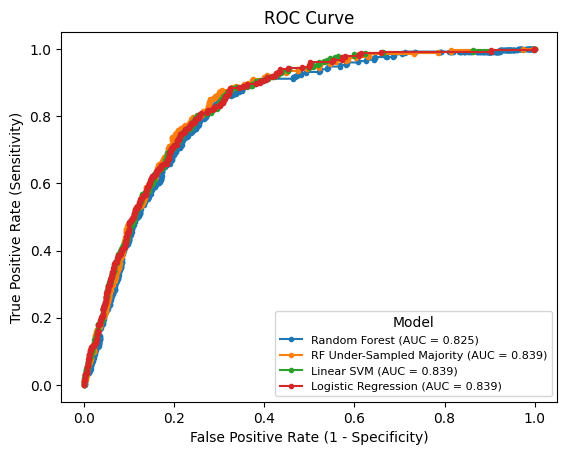

In [24]:
# ROC curve comparison
for model in ['Random Forest', 'RF Under-Sampled Majority', 'Linear SVM', 'Logistic Regression']:    
    clf_ROC(
        y_true=clf_pred_DF.y_true, 
        y_score=clf_pred_DICT[model]['y_score'], 
        roc_label=model
    )
    plt.legend(prop={'size': 8}, title='Model')

### Probabilistic Prediction Distributions

We can see that the RF and Linear SVM models have probabilistic prediction distributions that heavily favor the majority class. The Linear SVM model results don't totally align with our binary prediction results, however. Digging through the SVM documentation, I found that we can expect there to be inconsistincies here. Since SVM models don't inherently produce a probability to go along with the prediction, the probabilities are estimated using Platt scaling (i.e. logistic regression on the SVM’s scores). In general, the linear SVM model probably doesn't make a ton of sense here, and the results are likely not generalizable.

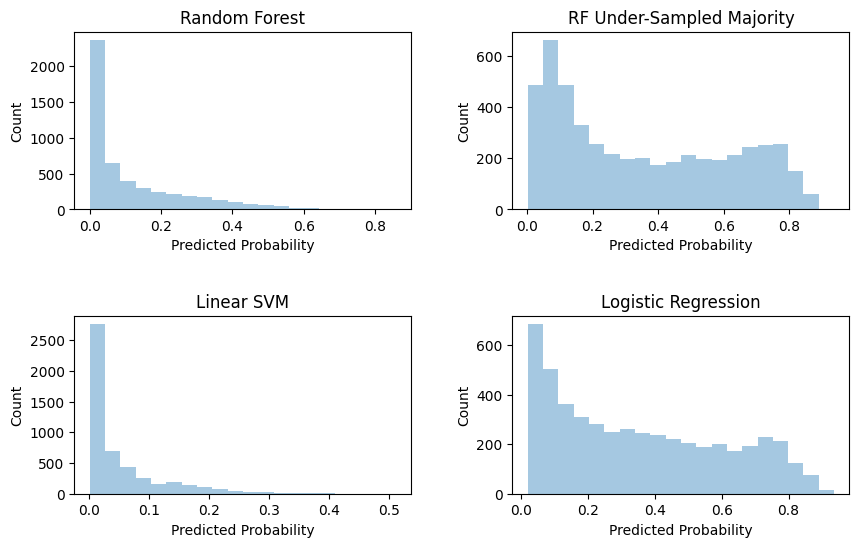

In [25]:
# Set plot space
fig, axs = plt.subplots(2, 2, figsize=(10, 6), gridspec_kw={"hspace": 0.6, "wspace": 0.3})
plots = []
for ax in axs:
    for plot in ax:
        plots.append(plot)

# Display probabilistic prediction distributions for each model
for i, model in enumerate(['Random Forest', 'RF Under-Sampled Majority', 'Linear SVM', 'Logistic Regression']):  
    sns.distplot(clf_pred_DICT[model]['y_score'], hist=True, kde=False, bins=20, label=model, ax=plots[i])
    plots[i].set_xlabel('Predicted Probability')
    plots[i].set_ylabel('Count')
    plots[i].set_title(model)

Overlaying the densities show that the probabilistic prediction distributions of the RF-USM and LogReg models are *very* similar

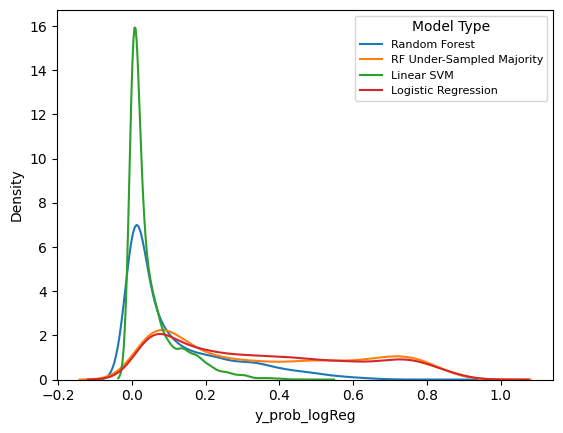

In [26]:
# Display probabilistic prediction distributions for each model
for model in ['Random Forest', 'RF Under-Sampled Majority', 'Linear SVM', 'Logistic Regression']:  
    sns.distplot(clf_pred_DICT[model]['y_score'], hist=False, kde=True, label=model)
    plt.legend(prop={'size': 8}, title='Model Type')

### Final Model Selection

In this scenario we care more about the performance in the negative class. We want to maximize the F1-score wrt to the negative class. This represents the greatest balance in maximizing true negative rate and minimizing false negative rate. The model that we will therefore select is the **Logistic Regression model**, which has a an F1-score of 0.84 for the negative class. If we were looking at this from a diagnosis point of view, where the priority would become making sure we didn't miss anyone in the positive class, we might opt for the RF-USM model.